In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
dataset_path = "/content/drive/MyDrive/garbage-dataset"


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
device

'cuda'

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

train_path = "/content/garbage_dataset_train"
test_path = "/content/garbage_dataset_test"

os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

classes = ["battery","biological","cardboard","clothes","glass","metal","paper","plastic","shoes","trash"]

for cls in classes:
    cls_path = os.path.join(dataset_path,cls)
    images = os.listdir(cls_path)
    train_images,test_images = train_test_split(images,test_size=0.2,random_state=42)

    os.makedirs(os.path.join(train_path,cls),exist_ok=True)
    os.makedirs(os.path.join(test_path,cls),exist_ok=True)

    for image in train_images:
        shutil.copy(os.path.join(cls_path,image),os.path.join(train_path,cls,image))
    for image in test_images:
        shutil.copy(os.path.join(cls_path,image),os.path.join(test_path,cls,image))



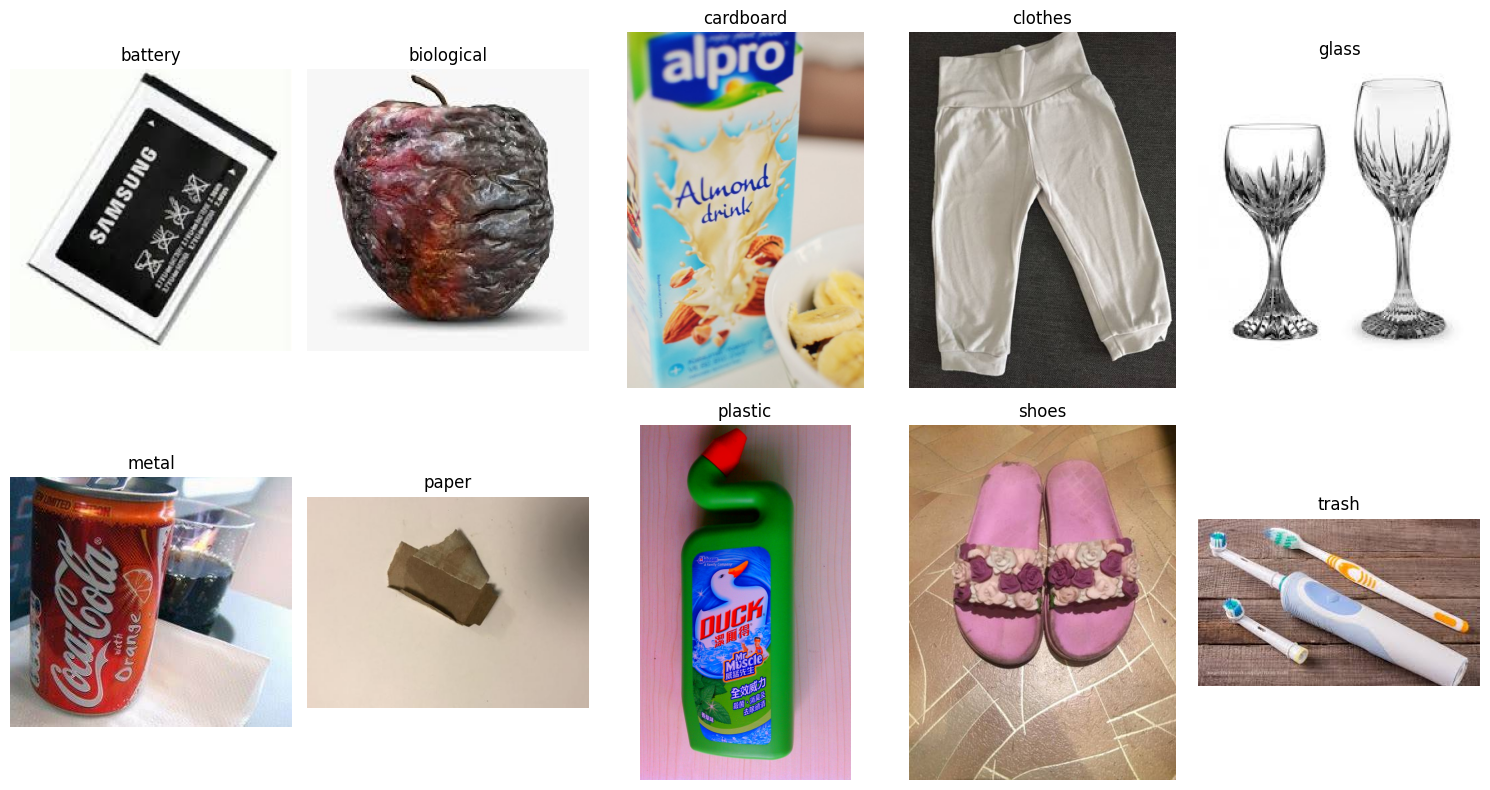

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Show one image per class from train folder
plt.figure(figsize=(15,8))

for i, cls in enumerate(classes):
    class_folder = os.path.join(train_path, cls)
    img_name = os.listdir(class_folder)[0]  # pick first image
    img_path = os.path.join(class_folder, img_name)

    img = mpimg.imread(img_path)

    plt.subplot(2, 5, i+1)  # 2 rows, 5 cols for 10 classes
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import torch
class GarbageDataset(Dataset):
  def __init__(self,root_dir,transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.classes = os.listdir(root_dir)
    self.images = []
    self.labels = []

    for i,cls in enumerate(self.classes):
      cls_path = os.path.join(root_dir,cls)
      for image in os.listdir(cls_path):
        self.images.append(os.path.join(cls_path,image))
        self.labels.append(i)

  def __len__(self):
    return len(self.images)


  def __getitem__(self,idx):
    image_path = self.images[idx]
    image = Image.open(image_path).convert("RGB")
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image,torch.tensor(label,dtype=torch.long)





In [37]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0.1),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [38]:
train_dataset = GarbageDataset(train_path,transform=train_transform)
test_dataset = GarbageDataset(test_path,transform=test_transform)

In [39]:
train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True,num_workers=2)
test_dataloader = DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True,num_workers=2)

In [40]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # adaptive avgpool → ensures fixed size regardless of input
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)          # ensures 6×6 feature maps
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [41]:
model = AlexNet()

In [42]:
model = model.to(device)

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)


In [48]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=5)

In [49]:
epochs =20

Epoch [1/20] | Train Loss: 1.7657, Train Acc: 0.4007 | Val Loss: 1.4651, Val Acc: 0.4901
Best model saved!
Epoch [2/20] | Train Loss: 1.3542, Train Acc: 0.5394 | Val Loss: 1.1996, Val Acc: 0.5938
Best model saved!
Epoch [3/20] | Train Loss: 1.1700, Train Acc: 0.6038 | Val Loss: 1.0305, Val Acc: 0.6580
Best model saved!
Epoch [4/20] | Train Loss: 1.0365, Train Acc: 0.6518 | Val Loss: 0.9692, Val Acc: 0.6787
Best model saved!
Epoch [5/20] | Train Loss: 0.9149, Train Acc: 0.6886 | Val Loss: 0.8900, Val Acc: 0.7075
Best model saved!
Epoch [6/20] | Train Loss: 0.8241, Train Acc: 0.7282 | Val Loss: 0.8063, Val Acc: 0.7366
Best model saved!
Epoch [7/20] | Train Loss: 0.7537, Train Acc: 0.7510 | Val Loss: 0.7709, Val Acc: 0.7394
Best model saved!
Epoch [8/20] | Train Loss: 0.6826, Train Acc: 0.7750 | Val Loss: 0.7546, Val Acc: 0.7480
Best model saved!
Epoch [9/20] | Train Loss: 0.6344, Train Acc: 0.7905 | Val Loss: 0.6716, Val Acc: 0.7854
Best model saved!
Epoch [10/20] | Train Loss: 0.5849, T

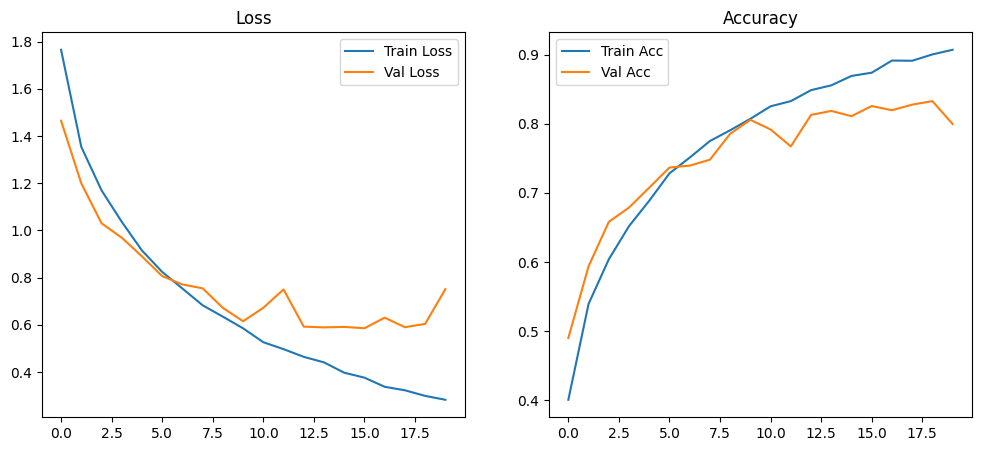

In [50]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Trackers
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0

# Folder to save model and plots
save_dir = "/content/drive/MyDrive/Garbage_model"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(epochs):
    # --- TRAIN ---
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = total_loss / len(train_dataloader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- VALIDATION ---
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_dataloader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # --- Save best model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model_alexnet.pth"))
        print("Best model saved!")
    scheduler.step(val_loss)

# --- Plot loss & accuracy ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.savefig(os.path.join(save_dir, "loss_accuracy_plot.png"))
plt.show()


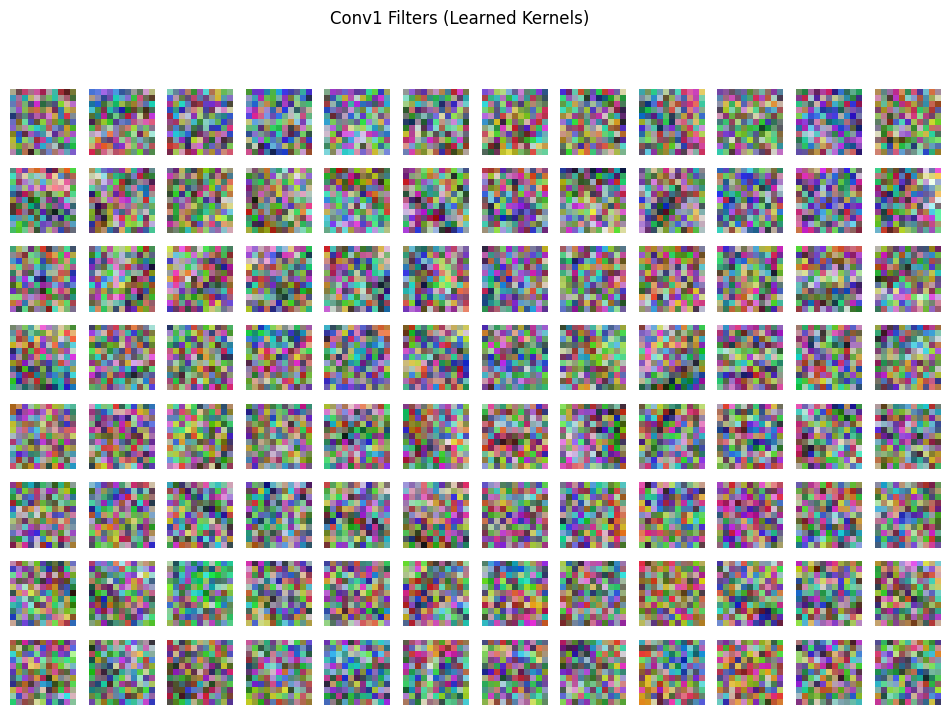

In [58]:
import matplotlib.pyplot as plt

# First conv layer weights
filters = model.features[0].weight.data.clone()

# Move to CPU and convert to numpy
filters = filters.cpu()

# Normalize for visualization
filters = (filters - filters.min()) / (filters.max() - filters.min())
filters = filters.numpy()  # optional, matplotlib can handle torch tensor too

fig, axs = plt.subplots(8, 12, figsize=(12, 8))
for i in range(96):   # Conv1 has 96 filters
    ax = axs[i // 12, i % 12]
    ax.imshow(filters[i].transpose(1, 2, 0))  # (C,H,W) -> (H,W,C)
    ax.axis("off")

plt.suptitle("Conv1 Filters (Learned Kernels)")
plt.show()


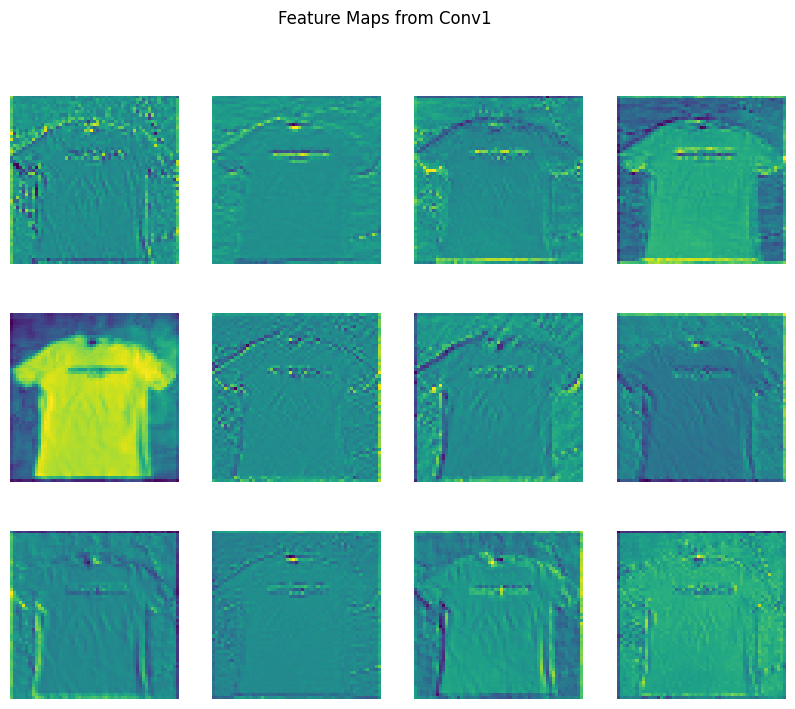

In [59]:
# Hook to capture intermediate outputs
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hook on Conv1
model.features[0].register_forward_hook(get_activation('conv1'))

# Load one sample image
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

img = Image.open("/content/garbage_dataset_test/clothes/clothes_1007.jpg")
input_tensor = transform(img).unsqueeze(0).to(device)  # Move input to same device as model

# Forward pass
output = model(input_tensor)

# Get activations
act = activation['conv1'].squeeze()  # shape: (96, H, W)

# Plot first 12 feature maps
fig, axs = plt.subplots(3, 4, figsize=(10, 8))
for i in range(12):
    ax = axs[i // 4, i % 4]
    ax.imshow(act[i].cpu(), cmap="viridis")
    ax.axis("off")

plt.suptitle("Feature Maps from Conv1")
plt.show()


In [69]:
classes =train_dataset.classes

In [83]:
def predict(image_path):
    image = Image.open(image_path).convert("RGB")
    image = test_transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _,predicted = torch.max(output.data,1)
    return classes[predicted.item()]
predict("/content/garbage_dataset_test/trash/trash_106.jpg")

'trash'